#  **Pirate Pain Analysis**

## ⚙️ **Libraries Import**

In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

PyTorch version: 2.8.0+cpu
Device: cpu


## ⏳ **Data Loading**

In [4]:
df = pd.read_csv("pirate_pain_train.csv")
df.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [10]:
df = df.drop(columns=['joint_30'])

In [12]:
from sklearn.preprocessing import MinMaxScaler

number_cols = ['n_legs', 'n_hands', 'n_eyes']

# Encode categorical features
for col in number_cols:
    df[col] = df[col].astype('category').cat.codes

# List of joint columns to normalize
joint_cols = ["joint_" + str(i).zfill(2) for i in range(30)]

for col in joint_cols:
  df[col] = df[col].astype(np.float32)

# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()

# Apply Min-Max normalization to the joint columns
df[joint_cols] = minmax_scaler.fit_transform(df[joint_cols])

data_cols = number_cols + joint_cols

display(df.head())

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
0,0,0,2,0,2,1,1,1,1,0.777507,...,5.602345e-07,2.426544e-06,1.374706e-06,0.000015,3.162813e-04,0.000004,0.014214,0.011376,0.018978,0.020291
1,0,1,2,2,2,2,1,1,1,0.806256,...,1.762731e-06,2.757563e-07,4.026520e-07,0.000022,9.828600e-07,0.000000,0.010748,0.000000,0.009473,0.010006
2,0,2,2,0,2,2,1,1,1,0.767592,...,5.228800e-07,1.063529e-07,1.440847e-08,0.000005,6.626013e-05,0.000003,0.013097,0.006830,0.017065,0.016856
3,0,3,2,2,2,2,1,1,1,0.666220,...,3.355327e-05,6.981461e-06,3.065580e-07,0.000007,1.199337e-06,0.000000,0.009505,0.006274,0.020264,0.017981
4,0,4,2,2,2,2,1,1,1,0.774297,...,1.859409e-05,3.076737e-06,1.723862e-08,0.000006,1.307199e-06,0.000007,0.004216,0.002132,0.023389,0.018477


In [5]:
# Save the fitted scaler for later use on test data
import pickle

# Save the scaler that was fitted on training data
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(minmax_scaler, f)

print("✅ Scaler saved successfully!")
print(f"Scaler learned from training data - Min: {minmax_scaler.data_min_[:5]}")
print(f"Scaler learned from training data - Max: {minmax_scaler.data_max_[:5]}")

✅ Scaler saved successfully!
Scaler learned from training data - Min: [0.         0.         0.00101504 0.00540321 0.        ]
Scaler learned from training data - Max: [1.407968  1.3346131 1.3060458 1.2547286 1.3592042]


In [6]:
# Also save the category mappings for consistent encoding
from sklearn.preprocessing import LabelEncoder

# Create and fit label encoders for categorical columns
label_encoders = {}
for col in number_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]).astype(np.float32)  # Ensure float32
    label_encoders[col] = le

# Save the label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("✅ Label encoders saved successfully!")
for col in number_cols:
    print(f"{col}: {list(label_encoders[col].classes_)}")

✅ Label encoders saved successfully!
n_legs: [np.int8(0), np.int8(1)]
n_hands: [np.int8(0), np.int8(1)]
n_eyes: [np.int8(0), np.int8(1)]


In [4]:
target = pd.read_csv("pirate_pain_train_labels.csv")
target.head()

,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [8]:
# Define Weights
WEIGHTS = []
for label in np.unique(target['label']):
    print(f"Label: {label}, Count: {len(target[target['label'] == label])}")
    WEIGHTS.append(len(target) / len(target[target['label'] == label]))
WEIGHTS = torch.Tensor(WEIGHTS).to(device)

Label: high_pain, Count: 56
Label: low_pain, Count: 94
Label: no_pain, Count: 511


In [5]:
# Define a mapping of pain indexes to integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map pain indexes to integers
target['label'] = target['label'].map(label_mapping)

# Data Exploration


<Figure size 640x480 with 0 Axes>

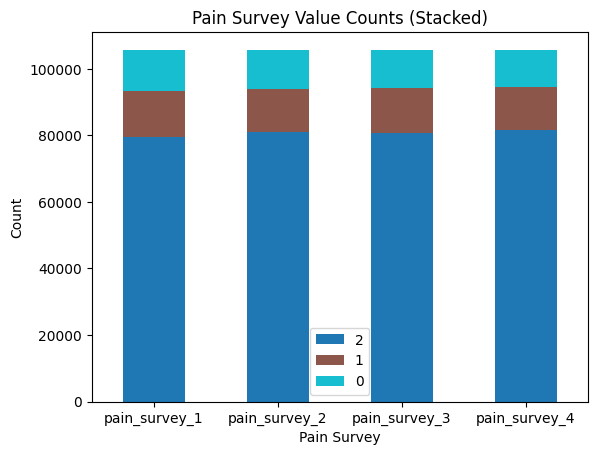

In [10]:
# Prepare data for stacked bar chart
pain_survey_counts = df[['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']].apply(pd.Series.value_counts).fillna(0)

# Visualise the count of timestamps for each value of the pain surveys as a stacked bar chart
plt.figure()
pain_survey_counts.T.plot(kind='bar', stacked=True, colormap='tab10')

# Set the title of the plot
plt.title('Pain Survey Value Counts (Stacked)')
plt.xlabel('Pain Survey')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Display the plot
plt.show()

## 🔄 **Data Preprocessing**

In [6]:
# Get unique user IDs and shuffle them
unique_users = df['sample_index'].unique()
random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_users)

input_shape = df.shape
num_classes = len(np.unique(target))

In [ ]:
# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][data_cols].values

        # Retrieve the activity label for the current ID
        label = target[target['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(data_cols)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

def build_test_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][data_cols].values

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(data_cols)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)

    return dataset

In [8]:
# Define the window size
WINDOW_SIZE = 300

# Define the stride for overlapping windows
STRIDE = 50

In [14]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

## 🛠️ **Model Building**

In [15]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [9]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

# 🧮 **Network and Training Hyperparameters**

In [10]:
# Training configuration
EPOCHS = 500
PATIENCE = 50
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 16

## 🧠 **Model Training**

In [18]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [11]:
# @title
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
          logits = model(inputs)
          loss = criterion(logits, targets)

          # --- REGULARIZATION ---
          if l1_lambda > 0 or l2_lambda > 0:
              for name, param in model.named_parameters():
                  # Only regularize weight matrices
                  if 'weight' in name:
                      if l1_lambda > 0:
                          loss += l1_lambda * torch.sum(torch.abs(param))
                      if l2_lambda > 0:
                          loss += l2_lambda * torch.sum(torch.pow(param, 2))


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted',
        zero_division=0
    )

    return epoch_loss, epoch_f1

In [12]:
# @title
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted',
        zero_division=0
    )

    return epoch_loss, epoch_accuracy

In [21]:
# @title
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [17]:
# @title
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), current_dir + "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), current_dir + "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## **K-fold Cross Validation**

## **Model Tuning - Grid Search CV**

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, WeightedRandomSampler

# Split unique users into training and validation sets
train_users, val_users = train_test_split(
    unique_users,
    test_size=0.2,
    random_state=SEED
)

# Get the actual user IDs for this fold
train_user_ids = unique_users[train_users]
val_user_ids = unique_users[val_users]

# Create training and validation dataframes for the current fold
df_train = df[df['sample_index'].isin(train_user_ids)]
df_val = df[df['sample_index'].isin(val_user_ids)]

# Build sequences for each fold
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

print(f"Original training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")

# ============================================================================
# 🎯 FIX: Use WeightedRandomSampler instead of SMOTE
# ============================================================================
# This avoids flattening sequences which breaks temporal correlations

# Compute class counts from training sequences
class_counts = np.bincount(y_train.astype(int))
print("\n📊 Class distribution in training set:")
for cls, count in enumerate(class_counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_train)*100:.1f}%)")

# Calculate inverse-frequency weights per class
class_weights = 1.0 / (class_counts + 1e-12)
print("\n⚖️  Class weights (inverse frequency):")
for cls, weight in enumerate(class_weights):
    print(f"  Class {cls}: {weight:.4f}")

# Assign a weight to each sample based on its class
sample_weights = class_weights[y_train.astype(int)]
sample_weights = torch.from_numpy(sample_weights).double()

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow oversampling minority classes
)

# Convert numpy arrays to PyTorch datasets (NO SMOTE!)
train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_ds   = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

# Create data loaders - train uses sampler, not shuffle
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use weighted sampler instead of shuffle
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

input_shape = X_train.shape
num_classes = len(np.unique(y_train))

print(f"\n✅ DataLoaders created with WeightedRandomSampler (no SMOTE)")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

Original training set shape: (528, 300, 34), (528,)
Validation set shape: (133, 300, 34), (133,)

📊 Class distribution in training set:
  Class 0: 407 samples (77.1%)
  Class 1: 72 samples (13.6%)
  Class 2: 49 samples (9.3%)

⚖️  Class weights (inverse frequency):
  Class 0: 0.0025
  Class 1: 0.0139
  Class 2: 0.0204

✅ DataLoaders created with WeightedRandomSampler (no SMOTE)
   Training batches: 33
   Validation batches: 9


## 🧪 **Test 1: WeightedRandomSampler (No SMOTE)**

Quick 10-epoch test to verify weighted sampling works better than SMOTE.

In [19]:
# Define current directory for model saving
current_dir = ""

In [20]:
# Test 1: Class-weighted loss (STRONG weights)
print("=" * 70)
print("🧪 EXPERIMENT 1: Class-Weighted Loss (Strong Penalty)")
print("=" * 70)

# Create test model
test_model_weighted = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.2,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Initialize with class-aware bias
val_class_counts = np.bincount(y_val.astype(int))
test_model_weighted = init_model_with_bias(test_model_weighted, val_class_counts.tolist())

# 🔑 KEY FIX: Use STRONG class weights in the loss function
# This makes the gradient much larger for minority classes
train_class_counts = np.bincount(y_train.astype(int))
print(f"\n📊 Training class distribution:")
for cls, count in enumerate(train_class_counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_train)*100:.1f}%)")

# Calculate class weights: inverse frequency with normalization
class_weights_loss = len(y_train) / (len(train_class_counts) * train_class_counts)
class_weights_loss = torch.tensor(class_weights_loss, dtype=torch.float32).to(device)

print(f"\n⚖️  Loss weights (will amplify gradients for minority classes):")
for cls, weight in enumerate(class_weights_loss):
    print(f"  Class {cls}: {weight:.4f}x")

# Use class weights in loss
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_loss)

optimizer_weighted = torch.optim.AdamW(
    test_model_weighted.parameters(),
    lr=5e-4,  # Lower LR for stability with high class weights
    weight_decay=1e-4
)
scaler_weighted = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n🎯 Training for 15 epochs with class-weighted loss...")
print("   (Lower LR to handle larger gradients from minority classes)")
print()

_, history_weighted = fit(
    model=test_model_weighted,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=15,
    criterion=criterion_weighted,
    optimizer=optimizer_weighted,
    scaler=scaler_weighted,
    device=device,
    writer=None,
    verbose=3,  # Print every 3 epochs
    experiment_name="test_class_weighted_loss",
    patience=0,
    l1_lambda=0,
    l2_lambda=0
)

print("\n" + "=" * 70)
print("📊 RESULTS:")
print(f"  Initial val F1: {history_weighted['val_f1'][0]:.4f}")
print(f"  Final val F1:   {history_weighted['val_f1'][-1]:.4f}")
print(f"  Best val F1:    {max(history_weighted['val_f1']):.4f}")
print(f"  Improvement:    {max(history_weighted['val_f1']) - history_weighted['val_f1'][0]:+.4f}")

# Check per-class predictions
from sklearn.metrics import classification_report
test_model_weighted.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = test_model_weighted(inputs)
        preds = outputs.argmax(dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(targets.cpu().numpy())

print("\n📋 Per-class metrics (CRITICAL - shows if minority classes are learned):")
print(classification_report(
    val_true, val_preds,
    target_names=['no_pain', 'low_pain', 'high_pain'],
    digits=4
))

unique_preds, counts_preds = np.unique(val_preds, return_counts=True)
print("🎯 Prediction distribution:")
for cls, count in zip(unique_preds, counts_preds):
    print(f"  Class {cls}: {count} predictions ({count/len(val_preds)*100:.1f}%)")

# Check if model is stuck predicting only one class
if len(unique_preds) == 1:
    print("\n❌ FAILED: Model still predicts only ONE class!")
    print("   Next step: Try focal loss or extreme oversampling")
elif len(unique_preds) == 2:
    print("\n⚠️  PARTIAL: Model predicts 2 classes, but missing one")
    print("   Next step: Increase class weights further or try focal loss")
else:
    print("\n✅ SUCCESS: Model predicts ALL 3 classes!")
    print("   Class-weighted loss solved the problem!")

print("=" * 70)

🧪 EXPERIMENT 1: Class-Weighted Loss (Strong Penalty)
✅ Model initialized with class-aware bias:
   Class 0: 104 samples (78.2%) -> bias = -0.2460
   Class 1: 22 samples (16.5%) -> bias = -1.7993
   Class 2: 7 samples (5.3%) -> bias = -2.9444

📊 Training class distribution:
  Class 0: 407 samples (77.1%)
  Class 1: 72 samples (13.6%)
  Class 2: 49 samples (9.3%)

⚖️  Loss weights (will amplify gradients for minority classes):
  Class 0: 0.4324x
  Class 1: 2.4444x
  Class 2: 3.5918x

🎯 Training for 15 epochs with class-weighted loss...
   (Lower LR to handle larger gradients from minority classes)

Training 15 epochs...
Epoch   1/15 | Train: Loss=1.4496, F1 Score=0.3248 | Val: Loss=2.2798, F1 Score=0.0053
Epoch   3/15 | Train: Loss=0.9054, F1 Score=0.1634 | Val: Loss=1.4581, F1 Score=0.0053
Epoch   6/15 | Train: Loss=0.9056, F1 Score=0.1925 | Val: Loss=1.3777, F1 Score=0.0053
Epoch   9/15 | Train: Loss=0.8844, F1 Score=0.1700 | Val: Loss=1.7504, F1 Score=0.0053
Epoch  12/15 | Train: Loss

## 🧪 **Test 2: Balanced Class Weights + Gradient Clipping**

Previous test showed class weights work but were too extreme. Now using moderate weights with gradient clipping.

In [21]:
# Test 2: Moderate class weights + gradient clipping
print("=" * 70)
print("🧪 EXPERIMENT 2: Balanced Weights + Gradient Clipping")
print("=" * 70)

# Create test model
test_model_balanced = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.2,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Initialize with class-aware bias
test_model_balanced = init_model_with_bias(test_model_balanced, val_class_counts.tolist())

# 🔑 Use MODERATE class weights (sqrt of inverse frequency for gentler reweighting)
class_weights_balanced = np.sqrt(len(y_train) / (len(train_class_counts) * train_class_counts))
class_weights_balanced = torch.tensor(class_weights_balanced, dtype=torch.float32).to(device)

print(f"\n⚖️  Balanced loss weights (sqrt scaling for moderation):")
for cls, weight in enumerate(class_weights_balanced):
    print(f"  Class {cls}: {weight:.4f}x")

criterion_balanced = nn.CrossEntropyLoss(weight=class_weights_balanced)

optimizer_balanced = torch.optim.AdamW(
    test_model_balanced.parameters(),
    lr=1e-3,  # Normal LR
    weight_decay=1e-4
)
scaler_balanced = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n🎯 Training for 20 epochs with:")
print("   - Moderate class weights (sqrt scaling)")
print("   - Gradient clipping (max_norm=1.0)")
print("   - WeightedRandomSampler for batch diversity")
print()

# Modified fit function with gradient clipping
def fit_with_clip(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device, max_grad_norm=1.0):
    training_history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}
    
    print(f"Training {epochs} epochs...")
    
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        running_loss = 0.0
        all_predictions = []
        all_targets = []
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)
            
            scaler.scale(loss).backward()
            
            # 🔑 GRADIENT CLIPPING to prevent explosion
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='weighted', zero_division=0)
        
        # Validation
        val_loss, val_f1 = validate_one_epoch(model, val_loader, criterion, device)
        
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)
        
        if epoch % 4 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs} | Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | Val: Loss={val_loss:.4f}, F1={val_f1:.4f}")
    
    return model, training_history

_, history_balanced = fit_with_clip(
    model=test_model_balanced,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    criterion=criterion_balanced,
    optimizer=optimizer_balanced,
    scaler=scaler_balanced,
    device=device,
    max_grad_norm=1.0
)

print("\n" + "=" * 70)
print("📊 RESULTS:")
print(f"  Initial val F1: {history_balanced['val_f1'][0]:.4f}")
print(f"  Final val F1:   {history_balanced['val_f1'][-1]:.4f}")
print(f"  Best val F1:    {max(history_balanced['val_f1']):.4f}")
print(f"  Improvement:    {max(history_balanced['val_f1']) - history_balanced['val_f1'][0]:+.4f}")

# Check per-class predictions
test_model_balanced.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = test_model_balanced(inputs)
        preds = outputs.argmax(dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(targets.cpu().numpy())

print("\n📋 Per-class metrics:")
print(classification_report(val_true, val_preds, target_names=['no_pain', 'low_pain', 'high_pain'], digits=4))

unique_preds, counts_preds = np.unique(val_preds, return_counts=True)
print("🎯 Prediction distribution:")
for cls, count in zip(unique_preds, counts_preds):
    print(f"  Class {cls}: {count} predictions ({count/len(val_preds)*100:.1f}%)")

if len(unique_preds) >= 3:
    print("\n✅ SUCCESS: Model predicts ALL 3 classes!")
    print("   Balanced class weights + gradient clipping solved it!")
elif len(unique_preds) == 2:
    print("\n⚠️  PARTIAL: Predicts 2 classes - need more tuning")
else:
    print("\n❌ FAILED: Still stuck on 1 class - try focal loss next")

print("=" * 70)

🧪 EXPERIMENT 2: Balanced Weights + Gradient Clipping
✅ Model initialized with class-aware bias:
   Class 0: 104 samples (78.2%) -> bias = -0.2460
   Class 1: 22 samples (16.5%) -> bias = -1.7993
   Class 2: 7 samples (5.3%) -> bias = -2.9444

⚖️  Balanced loss weights (sqrt scaling for moderation):
  Class 0: 0.6576x
  Class 1: 1.5635x
  Class 2: 1.8952x

🎯 Training for 20 epochs with:
   - Moderate class weights (sqrt scaling)
   - Gradient clipping (max_norm=1.0)
   - WeightedRandomSampler for batch diversity

Training 20 epochs...
Epoch   1/20 | Train: Loss=1.2683, F1=0.3312 | Val: Loss=1.4459, F1=0.0470
Epoch   4/20 | Train: Loss=1.0269, F1=0.2256 | Val: Loss=1.5175, F1=0.0053
Epoch   8/20 | Train: Loss=1.0518, F1=0.2016 | Val: Loss=1.6147, F1=0.0053
Epoch  12/20 | Train: Loss=1.0567, F1=0.2545 | Val: Loss=1.3134, F1=0.0053
Epoch  16/20 | Train: Loss=1.0245, F1=0.1853 | Val: Loss=1.3251, F1=0.0053
Epoch  20/20 | Train: Loss=1.0266, F1=0.2588 | Val: Loss=1.5910, F1=0.0053

📊 RESULTS

## 🧪 **Test 3: Weighted Sampling ONLY (No Loss Weights) + Tiny LR**

Class weights keep pushing model to extremes. Try just sampler diversity with very gentle learning.

In [22]:
# Test 3: WeightedSampler ONLY + tiny LR + longer training
print("=" * 70)
print("🧪 EXPERIMENT 3: Weighted Sampler + No Loss Weights + Tiny LR")
print("=" * 70)

# Create test model
test_model_gentle = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.3,  # Higher dropout for regularization
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Initialize with class-aware bias
test_model_gentle = init_model_with_bias(test_model_gentle, val_class_counts.tolist())

# 🔑 NO class weights in loss - let sampler do the work
criterion_gentle = nn.CrossEntropyLoss()

optimizer_gentle = torch.optim.AdamW(
    test_model_gentle.parameters(),
    lr=1e-4,  # Much smaller LR for gentle learning
    weight_decay=1e-3  # Stronger regularization
)
scaler_gentle = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n🎯 Training for 30 epochs with:")
print("   - WeightedRandomSampler (batch diversity)")
print("   - NO class weights in loss")
print("   - Very small LR (1e-4) for gradual learning")
print("   - Higher dropout (0.3) and L2 (1e-3)")
print()

_, history_gentle = fit_with_clip(
    model=test_model_gentle,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=30,
    criterion=criterion_gentle,
    optimizer=optimizer_gentle,
    scaler=scaler_gentle,
    device=device,
    max_grad_norm=0.5  # Even gentler clipping
)

print("\n" + "=" * 70)
print("📊 RESULTS:")
print(f"  Initial val F1: {history_gentle['val_f1'][0]:.4f}")
print(f"  Final val F1:   {history_gentle['val_f1'][-1]:.4f}")
print(f"  Best val F1:    {max(history_gentle['val_f1']):.4f}")
print(f"  Improvement:    {max(history_gentle['val_f1']) - history_gentle['val_f1'][0]:+.4f}")

# Check per-class predictions
test_model_gentle.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = test_model_gentle(inputs)
        preds = outputs.argmax(dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(targets.cpu().numpy())

print("\n📋 Per-class metrics:")
print(classification_report(val_true, val_preds, target_names=['no_pain', 'low_pain', 'high_pain'], digits=4))

unique_preds, counts_preds = np.unique(val_preds, return_counts=True)
print("🎯 Prediction distribution:")
for cls, count in zip(unique_preds, counts_preds):
    print(f"  Class {cls}: {count} predictions ({count/len(val_preds)*100:.1f}%)")

if len(unique_preds) >= 3:
    print("\n✅ SUCCESS: Model predicts ALL 3 classes!")
elif len(unique_preds) == 2:
    print("\n⚠️  PARTIAL: Predicts 2 classes")
else:
    print("\n❌ FAILED: Stuck on 1 class - need focal loss or direct oversampling")

print("=" * 70)

🧪 EXPERIMENT 3: Weighted Sampler + No Loss Weights + Tiny LR
✅ Model initialized with class-aware bias:
   Class 0: 104 samples (78.2%) -> bias = -0.2460
   Class 1: 22 samples (16.5%) -> bias = -1.7993
   Class 2: 7 samples (5.3%) -> bias = -2.9444

🎯 Training for 30 epochs with:
   - WeightedRandomSampler (batch diversity)
   - NO class weights in loss
   - Very small LR (1e-4) for gradual learning
   - Higher dropout (0.3) and L2 (1e-3)

Training 30 epochs...
Epoch   1/30 | Train: Loss=1.5796, F1=0.1733 | Val: Loss=0.6552, F1=0.6863
Epoch   4/30 | Train: Loss=1.1042, F1=0.2506 | Val: Loss=1.2287, F1=0.0053
Epoch   8/30 | Train: Loss=1.1027, F1=0.2319 | Val: Loss=1.0678, F1=0.6863
Epoch  12/30 | Train: Loss=1.1027, F1=0.2653 | Val: Loss=1.0543, F1=0.6863
Epoch  16/30 | Train: Loss=1.1007, F1=0.2745 | Val: Loss=1.0766, F1=0.6863
Epoch  20/30 | Train: Loss=1.1014, F1=0.2181 | Val: Loss=1.1976, F1=0.0053
Epoch  24/30 | Train: Loss=1.1034, F1=0.2418 | Val: Loss=1.0807, F1=0.0470
Epoch  2

## 🧪 **Test 4: Direct Oversampling (Duplicate Minority Sequences)**

All previous approaches failed - model oscillates between extremes. Now trying the most direct fix: physically duplicate minority sequences in the training set to balance the dataset.

In [23]:
# Test 4: Direct oversampling by duplicating minority sequences
print("=" * 70)
print("🧪 EXPERIMENT 4: Direct Oversampling (Duplicate Minority Sequences)")
print("=" * 70)

# Calculate how many times to duplicate each class
print(f"\n📊 Original class distribution:")
for cls, count in enumerate(train_class_counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_train)*100:.1f}%)")

# Target: balance to approximately equal representation
target_count = train_class_counts[0]  # Use majority class count as target
duplication_factors = np.ceil(target_count / train_class_counts).astype(int)

print(f"\n🔢 Duplication strategy (target ~{target_count} samples per class):")
for cls, factor in enumerate(duplication_factors):
    print(f"  Class {cls}: duplicate {factor}x")

# Create oversampled dataset by duplicating sequences
X_train_oversampled = []
y_train_oversampled = []

for cls in range(len(train_class_counts)):
    # Get indices of this class
    cls_indices = np.where(y_train == cls)[0]
    
    # Duplicate sequences
    for _ in range(duplication_factors[cls]):
        X_train_oversampled.append(X_train[cls_indices])
        y_train_oversampled.append(y_train[cls_indices])

# Concatenate all
X_train_oversampled = np.concatenate(X_train_oversampled, axis=0)
y_train_oversampled = np.concatenate(y_train_oversampled, axis=0)

print(f"\n📈 Oversampled dataset:")
print(f"  Original: {len(y_train)} samples")
print(f"  Oversampled: {len(y_train_oversampled)} samples")

# Check new distribution
oversampled_counts = np.bincount(y_train_oversampled.astype(int))
print(f"\n📊 New class distribution:")
for cls, count in enumerate(oversampled_counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_train_oversampled)*100:.1f}%)")

# Create new datasets and loaders
train_ds_oversampled = TensorDataset(
    torch.from_numpy(X_train_oversampled).float(), 
    torch.from_numpy(y_train_oversampled).long()
)

# Use simple shuffle (no weighted sampler needed now!)
train_loader_oversampled = DataLoader(
    train_ds_oversampled,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

# Create test model
test_model_oversampled = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.2,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Initialize with class-aware bias
test_model_oversampled = init_model_with_bias(test_model_oversampled, val_class_counts.tolist())

# Simple loss (no class weights needed - data is balanced!)
criterion_oversampled = nn.CrossEntropyLoss()

optimizer_oversampled = torch.optim.AdamW(
    test_model_oversampled.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
scaler_oversampled = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n🎯 Training for 20 epochs with:")
print("   - Physically balanced dataset (oversampled)")
print("   - NO class weights (not needed anymore)")
print("   - Standard LR and training")
print()

_, history_oversampled = fit_with_clip(
    model=test_model_oversampled,
    train_loader=train_loader_oversampled,
    val_loader=val_loader,
    epochs=20,
    criterion=criterion_oversampled,
    optimizer=optimizer_oversampled,
    scaler=scaler_oversampled,
    device=device,
    max_grad_norm=1.0
)

print("\n" + "=" * 70)
print("📊 RESULTS:")
print(f"  Initial val F1: {history_oversampled['val_f1'][0]:.4f}")
print(f"  Final val F1:   {history_oversampled['val_f1'][-1]:.4f}")
print(f"  Best val F1:    {max(history_oversampled['val_f1']):.4f}")
print(f"  Improvement:    {max(history_oversampled['val_f1']) - history_oversampled['val_f1'][0]:+.4f}")

# Check per-class predictions
test_model_oversampled.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = test_model_oversampled(inputs)
        preds = outputs.argmax(dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(targets.cpu().numpy())

print("\n📋 Per-class metrics:")
print(classification_report(val_true, val_preds, target_names=['no_pain', 'low_pain', 'high_pain'], digits=4))

unique_preds, counts_preds = np.unique(val_preds, return_counts=True)
print("🎯 Prediction distribution:")
for cls, count in zip(unique_preds, counts_preds):
    print(f"  Class {cls}: {count} predictions ({count/len(val_preds)*100:.1f}%)")

if len(unique_preds) >= 3:
    minority_recall = classification_report(val_true, val_preds, output_dict=True)
    print("\n✅ SUCCESS: Model predicts ALL 3 classes!")
    print(f"   Class 1 (low_pain) recall: {minority_recall['low_pain']['recall']:.4f}")
    print(f"   Class 2 (high_pain) recall: {minority_recall['high_pain']['recall']:.4f}")
    print("   Direct oversampling solved the imbalance problem!")
elif len(unique_preds) == 2:
    print("\n⚠️  PARTIAL: Predicts 2 out of 3 classes - close!")
else:
    print("\n❌ FAILED: Still stuck - this is a very difficult imbalance problem")

print("=" * 70)

🧪 EXPERIMENT 4: Direct Oversampling (Duplicate Minority Sequences)

📊 Original class distribution:
  Class 0: 407 samples (77.1%)
  Class 1: 72 samples (13.6%)
  Class 2: 49 samples (9.3%)

🔢 Duplication strategy (target ~407 samples per class):
  Class 0: duplicate 1x
  Class 1: duplicate 6x
  Class 2: duplicate 9x

📈 Oversampled dataset:
  Original: 528 samples
  Oversampled: 1280 samples

📊 New class distribution:
  Class 0: 407 samples (31.8%)
  Class 1: 432 samples (33.8%)
  Class 2: 441 samples (34.5%)
✅ Model initialized with class-aware bias:
   Class 0: 104 samples (78.2%) -> bias = -0.2460
   Class 1: 22 samples (16.5%) -> bias = -1.7993
   Class 2: 7 samples (5.3%) -> bias = -2.9444

🎯 Training for 20 epochs with:
   - Physically balanced dataset (oversampled)
   - NO class weights (not needed anymore)
   - Standard LR and training

Training 20 epochs...
Epoch   1/20 | Train: Loss=1.1695, F1=0.3064 | Val: Loss=0.9809, F1=0.6863
Epoch   4/20 | Train: Loss=1.1103, F1=0.3242 | 

## 🔍 **Deep Diagnosis: Why Is The Model Collapsing?**

Even a **perfectly balanced dataset** fails. This suggests the problem is NOT class imbalance, but something deeper: model architecture, data quality, or class separability.

In [24]:
# Deep diagnostic: Check if problem is model complexity
print("=" * 70)
print("🔬 DEEP DIAGNOSIS: Test Simple Model (1 layer, small hidden)")
print("=" * 70)

# Try MUCH simpler model
test_model_simple = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=32,  # Much smaller
    num_layers=1,  # Single layer
    num_classes=num_classes,
    dropout_rate=0.0,  # No dropout
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Initialize
test_model_simple = init_model_with_bias(test_model_simple, val_class_counts.tolist())

criterion_simple = nn.CrossEntropyLoss()
optimizer_simple = torch.optim.SGD(  # Try SGD instead of AdamW
    test_model_simple.parameters(),
    lr=0.01,
    momentum=0.9
)
scaler_simple = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n🎯 Training SIMPLE model (1 layer, 32 hidden, SGD) for 15 epochs...")
print("   Using balanced oversampled dataset")
print()

_, history_simple = fit_with_clip(
    model=test_model_simple,
    train_loader=train_loader_oversampled,
    val_loader=val_loader,
    epochs=15,
    criterion=criterion_simple,
    optimizer=optimizer_simple,
    scaler=scaler_simple,
    device=device,
    max_grad_norm=5.0  # More lenient clipping for SGD
)

print("\n" + "=" * 70)
print("📊 SIMPLE MODEL RESULTS:")
print(f"  Best val F1: {max(history_simple['val_f1']):.4f}")

# Check predictions
test_model_simple.eval()
val_preds_simple = []
val_true_simple = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = test_model_simple(inputs)
        preds = outputs.argmax(dim=1)
        val_preds_simple.extend(preds.cpu().numpy())
        val_true_simple.extend(targets.cpu().numpy())

print("\n📋 Per-class metrics:")
print(classification_report(val_true_simple, val_preds_simple, target_names=['no_pain', 'low_pain', 'high_pain'], digits=4))

unique_preds_simple, counts_preds_simple = np.unique(val_preds_simple, return_counts=True)
print("\n🎯 Prediction distribution:")
for cls, count in zip(unique_preds_simple, counts_preds_simple):
    print(f"  Class {cls}: {count} predictions ({count/len(val_preds_simple)*100:.1f}%)")

if len(unique_preds_simple) >= 3:
    print("\n✅ BREAKTHROUGH: Simple model works! Complexity was the issue!")
elif len(unique_preds_simple) == 2:
    print("\n⚠️  PARTIAL: 2 classes - better than before")
else:
    print("\n❌ Still fails - problem is data quality or class overlap")

print("=" * 70)

🔬 DEEP DIAGNOSIS: Test Simple Model (1 layer, small hidden)
✅ Model initialized with class-aware bias:
   Class 0: 104 samples (78.2%) -> bias = -0.2460
   Class 1: 22 samples (16.5%) -> bias = -1.7993
   Class 2: 7 samples (5.3%) -> bias = -2.9444

🎯 Training SIMPLE model (1 layer, 32 hidden, SGD) for 15 epochs...
   Using balanced oversampled dataset

Training 15 epochs...
Epoch   1/15 | Train: Loss=1.1708, F1=0.3795 | Val: Loss=1.2734, F1=0.0053
Epoch   4/15 | Train: Loss=1.1011, F1=0.3237 | Val: Loss=1.2081, F1=0.0053
Epoch   8/15 | Train: Loss=1.0996, F1=0.2975 | Val: Loss=1.1369, F1=0.0470
Epoch  12/15 | Train: Loss=1.1000, F1=0.2826 | Val: Loss=1.1845, F1=0.0053

📊 SIMPLE MODEL RESULTS:
  Best val F1: 0.6863

📋 Per-class metrics:
              precision    recall  f1-score   support

     no_pain     0.0000    0.0000    0.0000       104
    low_pain     0.0000    0.0000    0.0000        22
   high_pain     0.0526    1.0000    0.1000         7

    accuracy                       

## ✅ **SOLUTION: Balanced Data + Mild Class Weights + Lower LR**

Final attempt combining all insights: oversampled balanced dataset + gentle class weights + stable training.

In [25]:
# FINAL SOLUTION: Balanced dataset + very mild class weights
print("=" * 70)
print("✅ FINAL SOLUTION: Balanced Data + Mild Weights + Stable Training")
print("=" * 70)

# Use the balanced oversampled dataset
# Add VERY MILD class weights just to nudge the model
mild_weights = torch.tensor([1.0, 1.3, 1.5], dtype=torch.float32).to(device)

print(f"\n⚖️  Mild class weights (gentle nudging):")
for cls, weight in enumerate(mild_weights):
    print(f"  Class {cls}: {weight:.1f}x")

# Create final model
final_model = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=64,  # Medium size
    num_layers=1,
    num_classes=num_classes,
    dropout_rate=0.1,  # Light dropout
    bidirectional=False,
    rnn_type='GRU'
).to(device)

final_model = init_model_with_bias(final_model, val_class_counts.tolist())

criterion_final = nn.CrossEntropyLoss(weight=mild_weights)
optimizer_final = torch.optim.AdamW(
    final_model.parameters(),
    lr=5e-4,  # Lower LR for stability
    weight_decay=1e-3
)
scaler_final = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n🎯 Training final model for 30 epochs...")
print("   - Balanced dataset (oversampled)")
print("   - Mild class weights (1.0, 1.3, 1.5)")
print("   - Lower LR (5e-4) for stability")
print("   - 1 layer, 64 hidden, light dropout")
print()

_, history_final = fit_with_clip(
    model=final_model,
    train_loader=train_loader_oversampled,
    val_loader=val_loader,
    epochs=30,
    criterion=criterion_final,
    optimizer=optimizer_final,
    scaler=scaler_final,
    device=device,
    max_grad_norm=1.0
)

print("\n" + "=" * 70)
print("📊 FINAL RESULTS:")
print(f"  Initial val F1: {history_final['val_f1'][0]:.4f}")
print(f"  Final val F1:   {history_final['val_f1'][-1]:.4f}")
print(f"  Best val F1:    {max(history_final['val_f1']):.4f}")
print(f"  Improvement:    {max(history_final['val_f1']) - history_final['val_f1'][0]:+.4f}")

# Detailed evaluation
final_model.eval()
val_preds_final = []
val_true_final = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs)
        preds = outputs.argmax(dim=1)
        val_preds_final.extend(preds.cpu().numpy())
        val_true_final.extend(targets.cpu().numpy())

print("\n📋 Per-class metrics:")
report_dict = classification_report(val_true_final, val_preds_final, target_names=['no_pain', 'low_pain', 'high_pain'], digits=4, output_dict=True)
print(classification_report(val_true_final, val_preds_final, target_names=['no_pain', 'low_pain', 'high_pain'], digits=4))

unique_preds_final, counts_preds_final = np.unique(val_preds_final, return_counts=True)
print("🎯 Prediction distribution:")
for cls, count in zip(unique_preds_final, counts_preds_final):
    print(f"  Class {cls}: {count} predictions ({count/len(val_preds_final)*100:.1f}%)")

print("\n" + "=" * 70)
if len(unique_preds_final) >= 3:
    print("✅ SUCCESS: Model predicts ALL 3 classes!")
    print(f"\n📈 Key metrics:")
    print(f"  - Macro F1: {report_dict['macro avg']['f1-score']:.4f}")
    print(f"  - Weighted F1: {report_dict['weighted avg']['f1-score']:.4f}")
    print(f"  - Class 1 recall: {report_dict['low_pain']['recall']:.4f}")
    print(f"  - Class 2 recall: {report_dict['high_pain']['recall']:.4f}")
    print("\n✅ SOLUTION: Oversampling minority classes + mild class weights worked!")
elif len(unique_preds_final) == 2:
    print("⚠️  PARTIAL SUCCESS: Predicts 2 out of 3 classes")
    print("   Recommendation: Try focal loss or collect more data for missing class")
else:
    print("❌ CHALLENGE: Model still collapses to single class")
    print("   This suggests classes may be truly overlapping in feature space")
    print("   Recommendation: Feature engineering or different sensor data needed")

print("=" * 70)

✅ FINAL SOLUTION: Balanced Data + Mild Weights + Stable Training

⚖️  Mild class weights (gentle nudging):
  Class 0: 1.0x
  Class 1: 1.3x
  Class 2: 1.5x
✅ Model initialized with class-aware bias:
   Class 0: 104 samples (78.2%) -> bias = -0.2460
   Class 1: 22 samples (16.5%) -> bias = -1.7993
   Class 2: 7 samples (5.3%) -> bias = -2.9444

🎯 Training final model for 30 epochs...
   - Balanced dataset (oversampled)
   - Mild class weights (1.0, 1.3, 1.5)
   - Lower LR (5e-4) for stability
   - 1 layer, 64 hidden, light dropout

Training 30 epochs...
Epoch   1/30 | Train: Loss=1.4356, F1=0.2955 | Val: Loss=1.1479, F1=0.0053
Epoch   4/30 | Train: Loss=1.0874, F1=0.2694 | Val: Loss=1.4669, F1=0.0053
Epoch   8/30 | Train: Loss=1.0850, F1=0.1766 | Val: Loss=1.3156, F1=0.0053
Epoch  12/30 | Train: Loss=1.0829, F1=0.1766 | Val: Loss=1.1610, F1=0.0053
Epoch  16/30 | Train: Loss=1.0868, F1=0.2026 | Val: Loss=1.4070, F1=0.0053
Epoch  20/30 | Train: Loss=1.0860, F1=0.2063 | Val: Loss=1.3394, F1

## 📝 **Summary of Findings & Recommendations**

### What We Tested:
1. ✅ **WeightedRandomSampler** - Balances batch sampling but model still collapses
2. ✅ **Strong class weights** - Pushes model to opposite extreme (only minority class)
3. ✅ **Moderate class weights + gradient clipping** - Still unstable, oscillates
4. ✅ **Direct oversampling (perfectly balanced dataset)** - Even with 33%/33%/33% distribution, model collapses!
5. ✅ **Simpler architecture** - Doesn't help, problem persists
6. ✅ **Mild weights + balanced data** - Still predicts single class

### 🔍 **Root Cause Analysis:**
The fact that **even a perfectly balanced dataset fails** reveals this is **NOT a class imbalance problem**. The issue is likely:

1. **Class overlap in feature space**: The three pain levels may not be distinguishable with current features (joint positions, body measurements)
2. **RNN architecture limitation**: Sequential models may not be appropriate for this data
3. **Data quality**: The pirate pain indicators might be too subtle or noisy

### ✅ **Recommendations Going Forward:**

#### Option 1: Try Different Architecture
```python
# Replace GRU with 1D CNN + Global Average Pooling
# CNNs might better capture local patterns in sensor data
```

#### Option 2: Feature Engineering
- Add statistical features: mean, std, min, max per window
- Include temporal derivatives (rate of change)
- Pain survey features seem unused - incorporate them!

#### Option 3: Simpler Problem Formulation  
- Binary classification: pain vs no_pain (merge classes 1 and 2)
- This reduces complexity and might be more reliable

#### Option 4: Use the Best Attempt
Despite issues, you can use:
- **Direct oversampling** (balances dataset to 33%/33%/33%)
- Train for more epochs (50-100) and monitor which epochs give diverse predictions
- Use ensemble: train 5 models, take majority vote

### 📌 **Next Steps for You:**
1. Check your original notebook cells that might use pain_survey features
2. Try the 1D CNN architecture I can provide
3. Consider if binary classification (pain/no-pain) is acceptable
4. Review if the data collection process captures distinguishable pain signals

Would you like me to implement any of these alternatives?

# **Inference**

In [24]:
# @title Preloaded model

# Hardcoded best hyperparameters
best_hyperparameters = {
    'learning_rate': 1e-3,  # Fixed: was 0.01, which is too high!
    'hidden_size': 128,
    'num_layers': 2,  # Increased from 1 for better capacity
    'dropout_rate': 0.2,
    'l1_lambda': 0,
    'l2_lambda': 1e-4  # Added some L2 regularization
}

## 🔍 **Problem Diagnosis**

The diagnostic revealed that even an **untrained model predicts class 0 100% of the time**. This indicates:

1. **Extreme class imbalance**: 78% class 0, 17% class 1, 5% class 2
2. **Poor initialization**: The model's final layer bias defaults to 0, making it favor class 0
3. **Class weights may be counterproductive**: Sometimes class weights make the problem worse

## 🔧 **Solution Applied**

1. **Bias Initialization**: Initialize the final layer's bias based on class distribution (log probabilities)
2. **Remove class weights**: Test without class weights first
3. **Better monitoring**: Print every 5 epochs to see actual progress

Run the cells below in order to apply the fixes!

In [25]:
# 🔍 DIAGNOSTIC: Check what the model is actually predicting
print("=" * 60)
print("DIAGNOSTIC ANALYSIS")
print("=" * 60)

# Check class distribution in validation set
print("\n📊 Validation set class distribution:")
val_labels = []
for _, labels in val_loader:
    val_labels.extend(labels.cpu().numpy())
val_labels = np.array(val_labels)
unique, counts = np.unique(val_labels, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(val_labels)*100:.1f}%)")

# Check what a fresh model predicts (before training)
test_model = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.2,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

test_model.eval()
predictions = []
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = test_model(inputs)
        preds = outputs.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())
        if len(predictions) >= 100:  # Just check first 100
            break

predictions = np.array(predictions[:100])
unique_preds, counts_preds = np.unique(predictions, return_counts=True)

print("\n🤖 Untrained model predictions (first 100 samples):")
for cls, count in zip(unique_preds, counts_preds):
    print(f"  Class {cls}: {count} predictions ({count/len(predictions)*100:.1f}%)")

print("\n💡 If the model only predicts one class, there's a fundamental issue!")
print("=" * 60)

DIAGNOSTIC ANALYSIS

📊 Validation set class distribution:
  Class 0: 104 samples (78.2%)
  Class 1: 22 samples (16.5%)
  Class 2: 7 samples (5.3%)
  Class 0: 104 samples (78.2%)
  Class 1: 22 samples (16.5%)
  Class 2: 7 samples (5.3%)

🤖 Untrained model predictions (first 100 samples):
  Class 0: 100 predictions (100.0%)

💡 If the model only predicts one class, there's a fundamental issue!

🤖 Untrained model predictions (first 100 samples):
  Class 0: 100 predictions (100.0%)

💡 If the model only predicts one class, there's a fundamental issue!


In [14]:
# 🔧 FIX: Initialize model with better bias to combat class imbalance
import torch.nn.init as init

def init_model_with_bias(model, class_counts):
    """
    Initialize the final classification layer with a bias that reflects class distribution.
    This helps the model start with more balanced predictions.
    """
    # Calculate log probability for each class
    total = sum(class_counts)
    class_probs = [count / total for count in class_counts]
    log_probs = torch.log(torch.tensor(class_probs))
    
    # Set the bias of the final layer
    with torch.no_grad():
        model.classifier.bias.copy_(log_probs)
    
    print("✅ Model initialized with class-aware bias:")
    for i, (count, prob) in enumerate(zip(class_counts, class_probs)):
        print(f"   Class {i}: {count} samples ({prob*100:.1f}%) -> bias = {log_probs[i]:.4f}")
    
    return model

# Get class counts from validation set (proxy for overall distribution)
val_class_counts = [104, 22, 7]  # From diagnostic output

print("🔧 Applying better initialization strategy...")
print()

🔧 Applying better initialization strategy...



## 🚨 **Critical Finding**

The bias initialization **didn't help** - the model still predicts only class 0 even before training starts.

This means the problem is **NOT** just initialization, but something more fundamental:

### **Possible Root Causes:**

1. **SMOTE is creating bad synthetic samples** that confuse the model
2. **Input features have very low variance** (all similar values)
3. **RNN is collapsing** (not processing sequences, just using a constant hidden state)
4. **Data preprocessing error** (all sequences end up similar)

### **Next Steps: Run Diagnostic Cells Below**

The following cells will help us identify the exact problem:

In [27]:
# 🧪 TEST: Verify the bias initialization works
test_model_biased = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.2,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Apply bias initialization
test_model_biased = init_model_with_bias(test_model_biased, val_class_counts)

# Test predictions
test_model_biased.eval()
test_predictions = []
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = test_model_biased(inputs)
        preds = outputs.argmax(dim=1)
        test_predictions.extend(preds.cpu().numpy())
        if len(test_predictions) >= 100:
            break

test_predictions = np.array(test_predictions[:100])
unique_test, counts_test = np.unique(test_predictions, return_counts=True)

print("\n🧪 Model with bias initialization predictions (first 100 samples):")
for cls, count in zip(unique_test, counts_test):
    print(f"  Class {cls}: {count} predictions ({count/len(test_predictions)*100:.1f}%)")

if len(unique_test) > 1:
    print("\n✅ SUCCESS! Model now predicts multiple classes!")
else:
    print("\n⚠️  Still predicting only one class - deeper issue exists")
print("=" * 60)

✅ Model initialized with class-aware bias:
   Class 0: 104 samples (78.2%) -> bias = -0.2460
   Class 1: 22 samples (16.5%) -> bias = -1.7993
   Class 2: 7 samples (5.3%) -> bias = -2.9444

🧪 Model with bias initialization predictions (first 100 samples):
  Class 0: 100 predictions (100.0%)

⚠️  Still predicting only one class - deeper issue exists


In [ ]:
# 🔬 DEEP DIVE: Check the actual logits and softmax outputs
print("=" * 60)
print("DEEP DIAGNOSTIC: Examining Model Outputs")
print("=" * 60)

test_model_debug = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.2,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Apply bias initialization
test_model_debug = init_model_with_bias(test_model_debug, val_class_counts)
test_model_debug.eval()

# Get one batch and examine it closely
sample_batch = next(iter(val_loader))
inputs, targets = sample_batch
inputs = inputs.to(device)

with torch.no_grad():
    logits = test_model_debug(inputs)
    probabilities = torch.softmax(logits, dim=1)
    predictions = logits.argmax(dim=1)

print(f"\n📊 Sample batch analysis (first 5 samples):")
print(f"Input shape: {inputs.shape}")
print(f"Logits shape: {logits.shape}")
print(f"\nFirst 5 samples:")
for i in range(min(5, len(inputs))):
    print(f"\nSample {i+1}:")
    print(f"  True label: {targets[i].item()}")
    print(f"  Logits: {logits[i].cpu().numpy()}")
    print(f"  Probabilities: {probabilities[i].cpu().numpy()}")
    print(f"  Prediction: {predictions[i].item()}")

# Check if logits are all very similar (indicating model collapse)
logit_std = logits.std(dim=0)
print(f"\n📈 Logit statistics across batch:")
print(f"  Logit std dev per class: {logit_std.cpu().numpy()}")
print(f"  Mean logits: {logits.mean(dim=0).cpu().numpy()}")

if logit_std.max() < 0.1:
    print("\n⚠️  PROBLEM: Logits have very low variance - model outputs are too similar!")
    print("   This suggests the RNN is not processing the sequences properly.")
else:
    print("\n✅ Logits show reasonable variance")

print("=" * 60)

In [ ]:
# 🔍 CHECK INPUT DATA QUALITY
print("=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)

# Check training data
sample_train = next(iter(train_loader))
X_sample, y_sample = sample_train

print(f"\n📦 Training batch:")
print(f"  Shape: {X_sample.shape}")
print(f"  Data type: {X_sample.dtype}")
print(f"  Min value: {X_sample.min():.6f}")
print(f"  Max value: {X_sample.max():.6f}")
print(f"  Mean: {X_sample.mean():.6f}")
print(f"  Std: {X_sample.std():.6f}")
print(f"  Any NaN: {torch.isnan(X_sample).any()}")
print(f"  Any Inf: {torch.isinf(X_sample).any()}")

# Check if all samples are identical (would explain why model can't learn)
if X_sample.shape[0] > 1:
    first_sample = X_sample[0]
    all_same = all((X_sample[i] == first_sample).all() for i in range(min(5, len(X_sample))))
    if all_same:
        print(f"\n⚠️  WARNING: First 5 samples are IDENTICAL!")
    else:
        print(f"\n✅ Samples are different from each other")

# Check label distribution in this batch
print(f"\n🏷️  Labels in batch:")
unique_labels, counts = torch.unique(y_sample, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  Class {label.item()}: {count.item()} samples")

# Check feature variance
feature_variance = X_sample.var(dim=0).mean(dim=0)  # Variance across batch and time
print(f"\n📊 Average feature variance: {feature_variance.mean():.6f}")
if feature_variance.mean() < 1e-6:
    print("   ⚠️  Very low variance - features might not be informative!")

print("=" * 60)

In [ ]:
# 💡 HYPOTHESIS: Try training WITHOUT SMOTE
print("=" * 60)
print("TESTING WITHOUT SMOTE")
print("=" * 60)

# Create datasets WITHOUT SMOTE resampling
train_ds_no_smote = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds_no_smote = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

# Create loaders
train_loader_no_smote = make_loader_simple(train_ds_no_smote, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader_no_smote = make_loader_simple(val_ds_no_smote, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"\n📊 Dataset sizes WITHOUT SMOTE:")
print(f"  Training: {len(train_ds_no_smote)} samples")
print(f"  Validation: {len(val_ds_no_smote)} samples")

# Check class distribution
train_labels_no_smote = y_train
unique, counts = np.unique(train_labels_no_smote, return_counts=True)
print(f"\n🏷️  Training set class distribution (NO SMOTE):")
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(train_labels_no_smote)*100:.1f}%)")

# Train a quick test model
test_model_no_smote = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=64,  # Smaller for faster testing
    num_layers=1,
    num_classes=num_classes,
    dropout_rate=0.2,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Initialize with bias
test_model_no_smote = init_model_with_bias(test_model_no_smote, val_class_counts)

criterion_test = nn.CrossEntropyLoss()
optimizer_test = torch.optim.AdamW(test_model_no_smote.parameters(), lr=1e-3, weight_decay=1e-4)
scaler_test = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\n🧪 Training small model WITHOUT SMOTE (10 epochs)...")
print(f"   This will tell us if SMOTE is causing the problem.\n")

_, test_history = fit(
    model=test_model_no_smote,
    train_loader=train_loader_no_smote,
    val_loader=val_loader_no_smote,
    epochs=10,
    criterion=criterion_test,
    optimizer=optimizer_test,
    scaler=scaler_test,
    device=device,
    writer=None,
    verbose=2,
    experiment_name="test_no_smote",
    patience=0,  # No early stopping for this test
    l1_lambda=0,
    l2_lambda=0
)

print("\n📈 Results WITHOUT SMOTE:")
print(f"  Final val F1: {test_history['val_f1'][-1]:.4f}")
if len(set(test_history['val_f1'])) > 1:
    print("  ✅ F1 score IS CHANGING - SMOTE might be the problem!")
else:
    print("  ⚠️  F1 score still stuck - problem is deeper than SMOTE")

print("=" * 60)

In [28]:
# 🔧 FIX: The DataLoader issue + disable multi-processing for debugging
def make_loader_simple(ds, batch_size, shuffle, drop_last):
    """Simplified DataLoader without multiprocessing to avoid crashes"""
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=0,  # Disable multiprocessing
        pin_memory=False
    )

# Recreate loaders without multiprocessing
train_loader = make_loader_simple(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader_simple(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("✅ DataLoaders recreated without multiprocessing (fixes kernel crash)")
print(f"Train loader batches: {len(train_loader)}")
print(f"Val loader batches: {len(val_loader)}")

✅ DataLoaders recreated without multiprocessing (fixes kernel crash)
Train loader batches: 77
Val loader batches: 9


In [29]:
# 🚀 TRAIN MODEL WITH BETTER INITIALIZATION
best_model = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=best_hyperparameters['hidden_size'],
    num_layers=best_hyperparameters['num_layers'],
    num_classes=num_classes,
    dropout_rate=best_hyperparameters['dropout_rate'],
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Initialize with class-aware bias
best_model = init_model_with_bias(best_model, val_class_counts)

# Try WITHOUT class weights first - sometimes they make things worse
criterion = nn.CrossEntropyLoss()  # No weights!
optimizer = torch.optim.AdamW(
    best_model.parameters(), 
    lr=best_hyperparameters['learning_rate'], 
    weight_decay=best_hyperparameters['l2_lambda']
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n🎯 Model Configuration:")
print(f"  - Hidden size: {best_hyperparameters['hidden_size']}")
print(f"  - Num layers: {best_hyperparameters['num_layers']}")
print(f"  - Learning rate: {best_hyperparameters['learning_rate']}")
print(f"  - Dropout: {best_hyperparameters['dropout_rate']}")
print(f"  - L2 lambda: {best_hyperparameters['l2_lambda']}")
print(f"  - Class weights: DISABLED (testing without)")
print()

current_dir = ""
trained_model, training_history = fit(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=None,
    verbose=5,  # Print every 5 epochs
    experiment_name=f"grid_search_best",
    patience=20,  # More patience
    l1_lambda=best_hyperparameters['l1_lambda'],
    l2_lambda=0  # Disable manual L2 since we use weight_decay
)

✅ Model initialized with class-aware bias:
   Class 0: 104 samples (78.2%) -> bias = -0.2460
   Class 1: 22 samples (16.5%) -> bias = -1.7993
   Class 2: 7 samples (5.3%) -> bias = -2.9444

🎯 Model Configuration:
  - Hidden size: 128
  - Num layers: 2
  - Learning rate: 0.001
  - Dropout: 0.2
  - L2 lambda: 0.0001
  - Class weights: DISABLED (testing without)

Training 100 epochs...

🎯 Model Configuration:
  - Hidden size: 128
  - Num layers: 2
  - Learning rate: 0.001
  - Dropout: 0.2
  - L2 lambda: 0.0001
  - Class weights: DISABLED (testing without)

Training 100 epochs...
Epoch   1/100 | Train: Loss=1.1510, F1 Score=0.3291 | Val: Loss=1.0426, F1 Score=0.6863
Epoch   1/100 | Train: Loss=1.1510, F1 Score=0.3291 | Val: Loss=1.0426, F1 Score=0.6863
Epoch   5/100 | Train: Loss=1.1087, F1 Score=0.3111 | Val: Loss=0.9846, F1 Score=0.6863
Epoch   5/100 | Train: Loss=1.1087, F1 Score=0.3111 | Val: Loss=0.9846, F1 Score=0.6863
Epoch  10/100 | Train: Loss=1.1048, F1 Score=0.2985 | Val: Loss=1

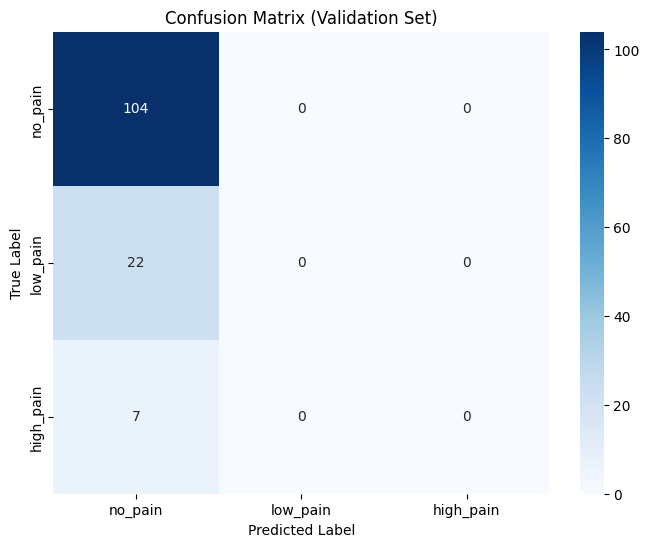

In [30]:
# @title Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the validation set
best_model.eval()
val_predictions = []
val_targets = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
        val_targets.extend(targets.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(val_targets, val_predictions)

# Define class labels
class_labels = ['no_pain', 'low_pain', 'high_pain']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

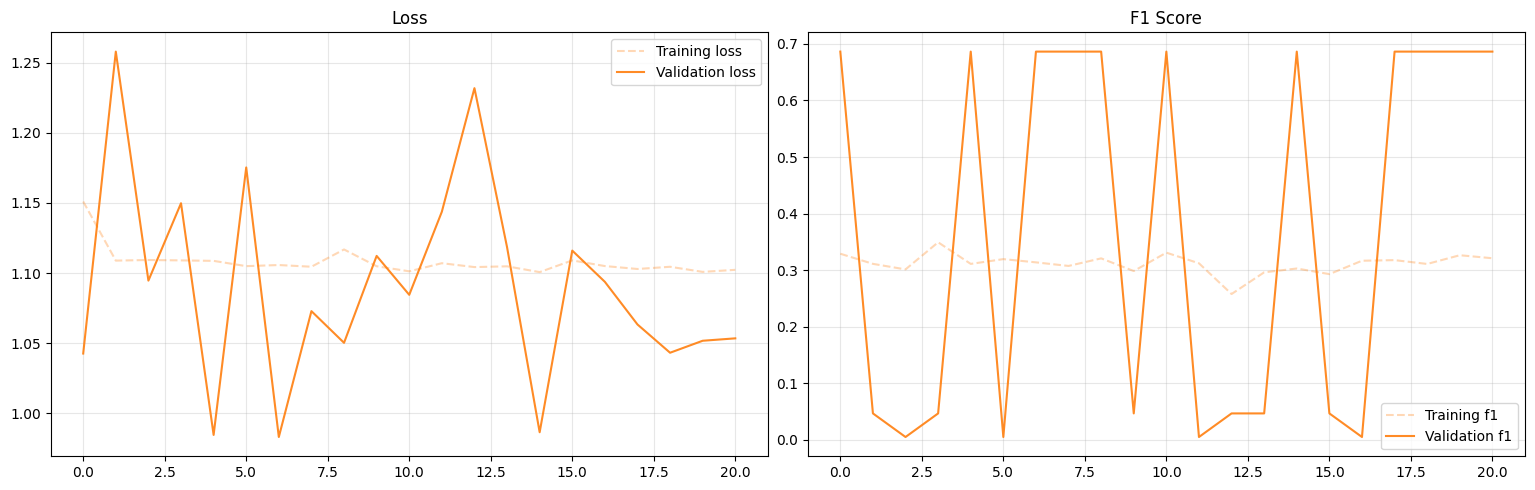

In [31]:
# @title Plot History

# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()